<a href="https://colab.research.google.com/github/Divyanshu-Singh-Chauhan/Image-Forgery-Detection/blob/master/2nd_research_paper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import time
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
import math

In [ ]:
 ##DEFINING THE PARAMETERS
(winW,winH) = (8,8)
stepsize = 2
#n_root = img.shape[0]
#e = 0.01             #fraction of the ignored variance along the principal axes
#q = 256               #number of quantization bins
nn = 2               #number of neighboring rows to search in the lexicographically sorted matrix
nf = 1         #minimum frequency threshold
nd = 30            #minimum offset threshold
n_components = 1
#nt is chosen s.t n_components = 16

In [ ]:
##Reading the image in Gray Scale
img = cv2.imread('/content/Aadhar_updated.png',1)
img_grey = cv2.imread('/content/Aadhar_updated.png',0)
img_grey_resize = cv2.resize(img_grey,(440,440))
#img2 = img_grey_resize[0:30,0:30]
img_resize = cv2.resize(img,(440,440))
print(img_resize.shape)
print(img_grey_resize.shape)
#print(img_resize.shape)
#img1 = img_resize[0:30,0:30]
#print(img1.shape)

(440, 440, 3)
(440, 440)


In [ ]:
class Blocks(object):
    """
    Contains a single image block and handle the calculation of characteristic features
    """

    def __init__(self, grayscale_image_block, rgb_image_block, x_coordinate, y_coordinate, block_dimension):
        """
        Initializing the input image
        :param grayscale_image_block: grayscale image block
        :param rgb_image_block: rgb image block
        :param x_coordinate: x coordinate (upper-left)
        :param y_coordinate: y coordinate (upper-left)
        :return: None
        """
        self.image_grayscale_pixels = grayscale_image_block  # block of grayscale image
        #self.image_grayscale_pixels = self.image_grayscale.load()

        if rgb_image_block is not None:
            self.image_rgb_pixels = rgb_image_block
            #self.image_rgb_pixels = self.image_rgb.load()
            self.is_image_rgb = True
        else:
            self.is_image_rgb = False

        self.coordinate = (x_coordinate, y_coordinate)
        self.block_dimension = block_dimension


    def compute_characteristic_features(self, precision):
        """
        Compute 7 characteristic features from every image blocks
        :param precision: feature characteristic precision
        :return: None
        """

        characteristic_feature_list = []

        # variable to compute characteristic features
        c4_part1 = 0
        c4_part2 = 0
        c5_part1 = 0
        c5_part2 = 0
        c6_part1 = 0
        c6_part2 = 0
        c7_part1 = 0
        c7_part2 = 0

        """ Compute c1, c2, c3 according to the image block's colorspace """

        if self.is_image_rgb:
            sum_of_red_pixel_value = 0
            sum_of_green_pixel_value = 0
            sum_of_blue_pixel_value = 0
            for y_coordinate in range(0, self.block_dimension):  # compute sum of the pixel value
                for x_coordinate in range(0, self.block_dimension):
                    tmp_red, tmp_green, tmp_blue = self.image_rgb_pixels[x_coordinate, y_coordinate]
                    sum_of_red_pixel_value += tmp_red
                    sum_of_green_pixel_value += tmp_green
                    sum_of_blue_pixel_value += tmp_blue

            sum_of_pixels = self.block_dimension * self.block_dimension
            sum_of_red_pixel_value = sum_of_red_pixel_value / (sum_of_pixels)  # mean from each of the colorspaces
            sum_of_green_pixel_value = sum_of_green_pixel_value / (sum_of_pixels)
            sum_of_blue_pixel_value = sum_of_blue_pixel_value / (sum_of_pixels)

            characteristic_feature_list.append(sum_of_red_pixel_value)
            characteristic_feature_list.append(sum_of_green_pixel_value)
            characteristic_feature_list.append(sum_of_blue_pixel_value)

        else:
            characteristic_feature_list.append(0)
            characteristic_feature_list.append(0)
            characteristic_feature_list.append(0)

        """ Compute  c4, c5, c6 and c7 according to the pattern rule on the second paper"""
        for y_coordinate in range(0, self.block_dimension):  # compute the part 1 and part 2 of each feature characteristic
            for x_coordinate in range(0, self.block_dimension):
                # compute c4
                if y_coordinate <= self.block_dimension / 2:
                    c4_part1 += self.image_grayscale_pixels[x_coordinate, y_coordinate]
                else:
                    c4_part2 += self.image_grayscale_pixels[x_coordinate, y_coordinate]
                # compute c5
                if x_coordinate <= self.block_dimension / 2:
                    c5_part1 += self.image_grayscale_pixels[x_coordinate, y_coordinate]
                else:
                    c5_part2 += self.image_grayscale_pixels[x_coordinate, y_coordinate]
                # compute c6
                if x_coordinate - y_coordinate >= 0:
                    c6_part1 += self.image_grayscale_pixels[x_coordinate, y_coordinate]
                else:
                    c6_part2 += self.image_grayscale_pixels[x_coordinate, y_coordinate]
                # compute c7
                if x_coordinate + y_coordinate <= self.block_dimension:
                    c7_part1 += self.image_grayscale_pixels[x_coordinate, y_coordinate]
                else:
                    c7_part2 += self.image_grayscale_pixels[x_coordinate, y_coordinate]

        if (float(c4_part1 + c4_part2)) == 0:
          characteristic_feature_list.append(0)
        else :
          characteristic_feature_list.append(float(c4_part1) / float(c4_part1 + c4_part2))

        if (float(c5_part1 + c5_part2)) == 0:
          characteristic_feature_list.append(0)
        else :
          characteristic_feature_list.append(float(c5_part1) / float(c5_part1 + c5_part2))

        if (float(c6_part1 + c6_part2)) == 0:
          characteristic_feature_list.append(0)
        else :
          characteristic_feature_list.append(float(c6_part1) / float(c6_part1 + c6_part2))                    

        if (float(c7_part1 + c7_part2)) == 0:
          characteristic_feature_list.append(0)
        else :
          characteristic_feature_list.append(float(c7_part1) / float(c7_part1 + c7_part2))
          
        precise_result = [round(element, precision) for element in characteristic_feature_list]
        return precise_result


In [ ]:
##DEFINING THE SLIDING WINDOW
def sliding_window(image, stepSize, windowSize):
	# slide a window across the image
	for y in range(0, image.shape[0], stepSize):
		for x in range(0, image.shape[1], stepSize):
			# yield the current window
			yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])

In [ ]:
coord_arr = []
def arr_generate(image):

  count = 1
  cnt = 0
  for (x, y, window) in sliding_window(image, stepSize=stepsize, windowSize=(winW, winH)):
    if window.shape[0]!=winH or window.shape[1]!= winW:
      continue
    window_gray = cv2.cvtColor(window, cv2.COLOR_BGR2GRAY)
    block = Blocks(window_gray,window,x,y,winW)
    char_feat = block.compute_characteristic_features(2)
    if count == 1:
      arr_flat = []
      count = 2
    coord_arr.append((x,y)) #### storing the top-left coordinates of each block
    #window = window.flatten()
    #window = window.tolist()
    arr_flat.append(char_feat)   

  return arr_flat

In [ ]:
arr = arr_generate(img_resize)

In [ ]:
arr = np.array(arr)

In [ ]:
arr.shape

(47089, 7)

In [ ]:
###Lexicographical Sorting 

def lexsort(x):
  return x[np.lexsort(np.rot90(x))]  

In [ ]:
##Sorted array created above through reduced features
arr_sorted = lexsort(arr)
print(arr_sorted[50:150])
##We have the sorted array

In [ ]:
arr_sorted_index = np.lexsort(np.rot90(arr))
print(arr_sorted_index)


###Now we have the index and the coordinates of the blocks and we need to reorder the coordinates list
#coord_arr  --- list of the cooordinates
#arr_sorted_index --- list of the indices of the sorted list

[15868 20367 16081 ...   132   215   216]


In [ ]:
arr_sorted_index = arr_sorted_index.tolist()

In [ ]:
### Finding the reordered list
#coord_arr_sorted = [x for y, x in sorted(zip(arr_sorted_index,coord_arr))]
coord_arr_sorted = []
for i in arr_sorted_index:
  coord_arr_sorted.append(coord_arr[i])
##Now we have the list of ordered coordinates of the image blocks

In [ ]:
#### Calculating the pairs of the characteristic feature layer given in eqn 6
nb = arr_sorted.shape[0]

char_pairs_list = []
for i in range(int(nb)):
  for j in range(i+1,i+nn) :
    if j < nb:
      char_pairs_list.append([arr_sorted[i],arr_sorted[j]])


#### Calculating the pairs given in eqn 6
nb = arr_sorted.shape[0]
pairs_list = []
for i in range(int(nb)):
  for j in range(i+1,i+nn) :
    if j < nb:
      pairs_list.append([coord_arr_sorted[i],coord_arr_sorted[j]])

In [ ]:
#### COMPUTING LIST OF OFFSETS

offset_list = []
for i in range(len(pairs_list)):
  if (pairs_list[i][0][0]-pairs_list[i][1][0]) == 0:
    offset_list.append([0,abs(pairs_list[i][0][1]-pairs_list[i][1][1])])
  else :
    offset_list.append([abs(pairs_list[i][0][0]-pairs_list[i][1][0]),pairs_list[i][0][1]-pairs_list[i][1][1]])

len(offset_list)

47088

In [ ]:
#### COMPUTING LIST OF OFFSETS of Character list

char_offset_list = []
for i in range(len(char_pairs_list)):
  each_list = []
  for j in range(arr.shape[1]):
    each_list.append(char_pairs_list[i][0][j]-char_pairs_list[i][1][j])
  char_offset_list.append(each_list)
  

In [ ]:
diff = np.array(char_offset_list)
print(diff.shape)
print(diff[0:4])

(47088, 7)
[[ 0.    0.    0.    0.    0.    0.    0.  ]
 [-0.02 -0.28  1.73  0.   -0.01  0.    0.  ]
 [ 0.   -0.49 -0.08  0.    0.    0.01  0.  ]
 [-0.01  0.74 -1.68  0.    0.01 -0.01  0.  ]]


In [ ]:
### COMPARISON PARAMETERS
p = np.array([1.8,1.8,1.8,0.0125,0.0125,0.0125,0.0125])
t1 = 2.8
t2 = 0.02
b = 16
l = 50

In [ ]:
def check_function(array):

  index = []
  for i in range(array.shape[0]):
    if int(all(array[i] < p)) == 1:      ### 1st check
      if (array[i][0] + array[i][1] + array[i][2]) < t1 :
        if (array[i][3] + array[i][4] + array[i][5] + array[i][6]) < t2 :
          array[i] = 0

  for i in range(array.shape[0]):
    if int(all(array[i] == 0)) == 1:
      index.append(i)

  return index

In [ ]:
indices = check_function(diff)

In [ ]:
len(indices)

20158

In [ ]:
#### COMPUTING LIST OF OFFSETS according to indices

offset_list = []
for i in indices:
  if (pairs_list[i][0][0]-pairs_list[i][1][0]) == 0:
    offset_list.append([0,abs(pairs_list[i][0][1]-pairs_list[i][1][1])])
  else :
    offset_list.append([abs(pairs_list[i][0][0]-pairs_list[i][1][0]),pairs_list[i][0][1]-pairs_list[i][1][1]])

len(offset_list)

20158

In [ ]:

### DISCARDING PAIRS WITH VALUES LESS THAN OFFSET FREQUENCY 
mp = dict()
def offset_freq(list1):
  lista = list1.copy()
  for i in range(len(lista)):
    if tuple(lista[i]) in mp.keys():
      mp[tuple(lista[i])] +=1
    else:
      mp[tuple(lista[i])] = 1

  for j in range(len(lista)):
    if mp[tuple(lista[j])]< nf:
      lista[j] = 0            
  return lista  



#### DISCARD FUNCTION FOR OFFSET MAGNITUDE

def offset_magnitude(lista):
  
  for i in range(len(lista)):
    if lista[i]!=0:
      magnitude = math.sqrt(lista[i][0]**2+lista[i][1]**2)
      if magnitude > nd:
        lista[i] = None
      else :
        lista[i] = 0      
      
  return lista  

In [ ]:
lista = offset_freq(offset_list)

In [ ]:
updated_offset_list = offset_magnitude(lista)

In [ ]:
len(updated_offset_list)

20158

In [ ]:
mp

In [ ]:
### MAPPING OF NONE ELEMENTS TO THE COORDINATES

## getting the indices of the None elements
res = [i for i, val in enumerate(updated_offset_list) if val == None]

### RETRIEVE THE DUPLICATED COORDINATE PAIRS 
updated_pairs_list = []
for i in res:
  updated_pairs_list.append(pairs_list[i]) 

In [ ]:
### Flattening the Updated_pairs_list
flat_list = []
for sublist in updated_pairs_list:
    for item in sublist:
        flat_list.append(item)

In [ ]:
len(flat_list)

31434

In [ ]:
### FINAL LIST CONSISTING OF TUPLES OF COORDINATES WITH DUPLICATIONS WHICH WILL BE DIRECTLY USED TO GENERATE THE GRAYSCALE IMAGE
unique = np.unique(flat_list, axis=0)

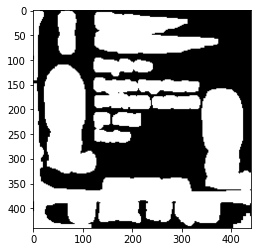

In [ ]:
### creating an array of the same size as that of resized input image
duplication = np.zeros((img_resize.shape[0],img_resize.shape[1]))

### Giving values to the duplicated regions as 255
for coord in unique:
  duplication[coord[0]:coord[0]+winW,coord[1]:coord[1]+winH] = 255  

duplication_rotate = cv2.rotate(duplication,cv2.ROTATE_90_COUNTERCLOCKWISE)
dup_aligned = cv2.flip(duplication_rotate,0)
### Showing the image
plt.gray
plt.imshow(dup_aligned, cmap = 'gray', vmin = 0, vmax = 255)  

In [ ]:
plt.imshow(img_resize)

**##############################################################**